In [1]:
# Global imports
import os
import numpy as np
import pandas as pd
import imageio.v2 as imageio
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import glob
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense


c:\Users\herna\anaconda3\envs\SpectroCNN\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\herna\anaconda3\envs\SpectroCNN\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [4]:
# mport train
df_train = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/train_split_Depression_AVEC2017.csv')
df_test = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/test_split_Depression_AVEC2017.csv')
df_test_full = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/full_test_split.csv')
df_dev = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/dev_split_Depression_AVEC2017.csv')

In [5]:
df_test_full['PHQ8_Score'] = df_test_full['PHQ_Score']
df_test_full.drop('PHQ_Binary', axis=1, inplace=True)

In [6]:
df_complete = pd.concat([df_test_full, df_dev, df_train], axis=0)

In [7]:
print(f'df_train: {df_train.shape[0]} rows\n'
      f'df_test_full: {df_test_full.shape[0]} rows\n'
      f'df_dev: {df_dev.shape[0]} rows\n'
      f'Total: {df_train.shape[0] + df_test_full.shape[0] + df_dev.shape[0]} rows \n\n'
      
      f'df_complete: {df_complete.shape[0]} rows\n'
      f'df_test: {df_test.shape[0] + df_test.shape[0] + df_test.shape[0]} rows (DISCARD)\n')
      


df_train: 107 rows
df_test_full: 47 rows
df_dev: 35 rows
Total: 189 rows 

df_complete: 189 rows
df_test: 141 rows (DISCARD)



In [8]:
def load_spectrogram(df):
    # Define root path of data
    root_path = 'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data'  # Replace with your root path

    # Add the column for spectrogram if it doesn't exist
    if 'Spectrogram' not in df.columns:
        # Define the shape of the fixed tensor
        tensor_shape = (292, 252, 3)  # Example shape (height, width, channels)

        # Create a fixed tensor of zeros with the desired shape
        fixed_tensor = np.zeros(tensor_shape, dtype=np.uint8)  # Adjust dtype as needed

        # Initialize the 'Spectrogram' column with the fixed tensor
        df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]

    # Handle missing values in 'Participant_ID' column
    df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')

    # Create an empty list to store modified rows
    modified_rows = []
    for index, row in df.iterrows():
            if not pd.isnull(row['Participant_ID']):  # Check if Participant_ID is not NaN
                participant_id = str(int(row['Participant_ID']))
                folder_path = os.path.join(root_path, str(participant_id) + '_P/resized')
                if os.path.isdir(folder_path):
                    # Flag to check if the first spectrogram has been loaded
                    first_loaded = False
                    # Iterate over image files in the folder
                    for image_file in glob.glob(os.path.join(folder_path, '*.jpg')):
                        image_path = os.path.join(folder_path, image_file)
                        if os.path.isfile(image_path):
                            # If it's the first spectrogram, add it to the original row
                            if not first_loaded:
                                image = imageio.imread(image_path)
                                row['Spectrogram'] = image
                                modified_rows.append(row)  # Add the modified row to the list
                                first_loaded = True
                            else:
                                # Create a copy of the original row
                                new_row = row.copy()
                                # Load the new image
                                new_image = imageio.imread(image_path)
                                # Assign the new image to the 'Spectrogram' column of the new row
                                new_row['Spectrogram'] = new_image
                                # Append the new row to the list
                                modified_rows.append(new_row)
                        else:
                            print(f"Image file not found at path {image_path}. Skipping...")
                else:
                    print(f"Folder not found at path {folder_path}. Skipping...")
                    raise Exception
    # Concatenate the original DataFrame with the modified rows
    #modified_df = pd.concat([df] + modified_rows, ignore_index=True)
    modified_df = pd.DataFrame(modified_rows)
    return modified_df
    #return df


------------------------------------------------------------------------
Evaluating for K = 3 ...
------------------------------------------------------------------------
------------------------------------------------------------------------
Evaluating for fold 1 ...


c:\Users\herna\anaconda3\envs\SpectroCNN\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Part

Epoch 1/100
61/61 [==============================] - 15s 189ms/step - loss: 3169.2153 - mean_absolute_error: 33.4522 - val_loss: 50973.6562 - val_mean_absolute_error: 182.0714 - lr: 0.0010
Epoch 2/100
61/61 [==============================] - 13s 217ms/step - loss: 124.1275 - mean_absolute_error: 8.0705 - val_loss: 512.7081 - val_mean_absolute_error: 12.7904 - lr: 0.0010
Epoch 3/100
61/61 [==============================] - 19s 311ms/step - loss: 96.0864 - mean_absolute_error: 7.8098 - val_loss: 24.3258 - val_mean_absolute_error: 3.9179 - lr: 0.0010
Epoch 4/100
61/61 [==============================] - 57s 945ms/step - loss: 67.0175 - mean_absolute_error: 6.4748 - val_loss: 24.1071 - val_mean_absolute_error: 3.9530 - lr: 0.0010
Epoch 5/100
61/61 [==============================] - 19s 311ms/step - loss: 58.4600 - mean_absolute_error: 6.1349 - val_loss: 23.0316 - val_mean_absolute_error: 3.5622 - lr: 0.0010
Epoch 6/100
61/61 [==============================] - 7s 106ms/step - loss: 51.2141 -

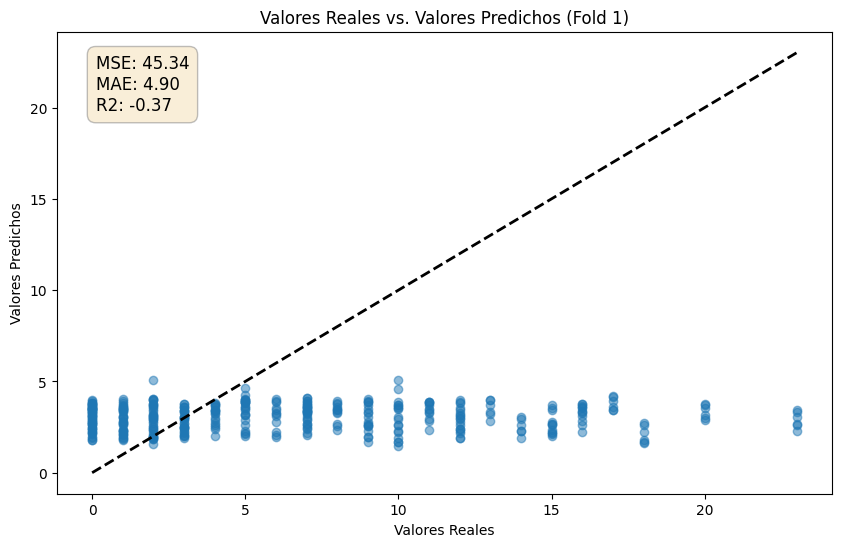

------------------------------------------------------------------------
Evaluating for fold 2 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
61/61 [==============================] - 12s 195ms/step - loss: 2842.8054 - mean_absolute_error: 28.6824 - val_loss: 1655.5361 - val_mean_absolute_error: 26.1443 - lr: 0.0010
Epoch 2/100
61/61 [==============================] - 12s 192ms/step - loss: 85.7670 - mean_absolute_error: 7.0399 - val_loss: 29.2278 - val_mean_absolute_error: 3.7550 - lr: 0.0010
Epoch 3/100
61/61 [==============================] - 12s 193ms/step - loss: 64.5666 - mean_absolute_error: 6.3150 - val_loss: 24.2173 - val_mean_absolute_error: 3.6042 - lr: 0.0010
Epoch 4/100
61/61 [==============================] - 7s 103ms/step - loss: 89.4958 - mean_absolute_error: 6.3549 - val_loss: 33.3253 - val_mean_absolute_error: 4.8297 - lr: 0.0010
Epoch 5/100
61/61 [==============================] - 6s 103ms/step - loss: 62.2556 - mean_absolute_error: 6.1499 - val_loss: 28.2362 - val_mean_absolute_error: 4.2667 - lr: 0.0010
Epoch 6/100
61/61 [==============================] - 6s 102ms/step - loss: 55.1263 - mean_a

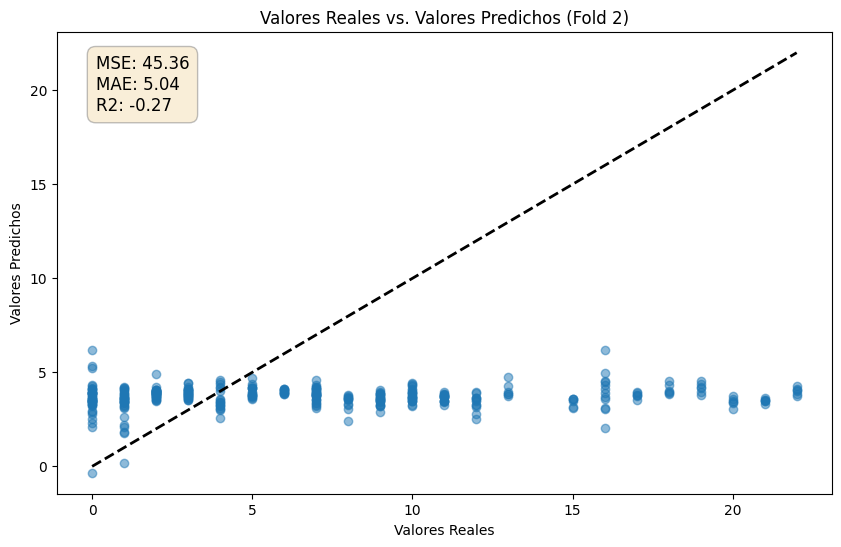

------------------------------------------------------------------------
Evaluating for fold 3 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
61/61 [==============================] - 14s 215ms/step - loss: 2904.9399 - mean_absolute_error: 32.1295 - val_loss: 63.3851 - val_mean_absolute_error: 5.3558 - lr: 0.0010
Epoch 2/100
61/61 [==============================] - 12s 191ms/step - loss: 88.9880 - mean_absolute_error: 7.1746 - val_loss: 34.2106 - val_mean_absolute_error: 3.6465 - lr: 0.0010
Epoch 3/100
61/61 [==============================] - 12s 201ms/step - loss: 57.9591 - mean_absolute_error: 6.1085 - val_loss: 31.4758 - val_mean_absolute_error: 3.7120 - lr: 0.0010
Epoch 4/100
61/61 [==============================] - 12s 194ms/step - loss: 53.1705 - mean_absolute_error: 5.8240 - val_loss: 30.7548 - val_mean_absolute_error: 3.8896 - lr: 0.0010
Epoch 5/100
61/61 [==============================] - 12s 195ms/step - loss: 62.8257 - mean_absolute_error: 6.0709 - val_loss: 30.1394 - val_mean_absolute_error: 3.8277 - lr: 0.0010
Epoch 6/100
61/61 [==============================] - 10s 169ms/step - loss: 123.4251 - mean_

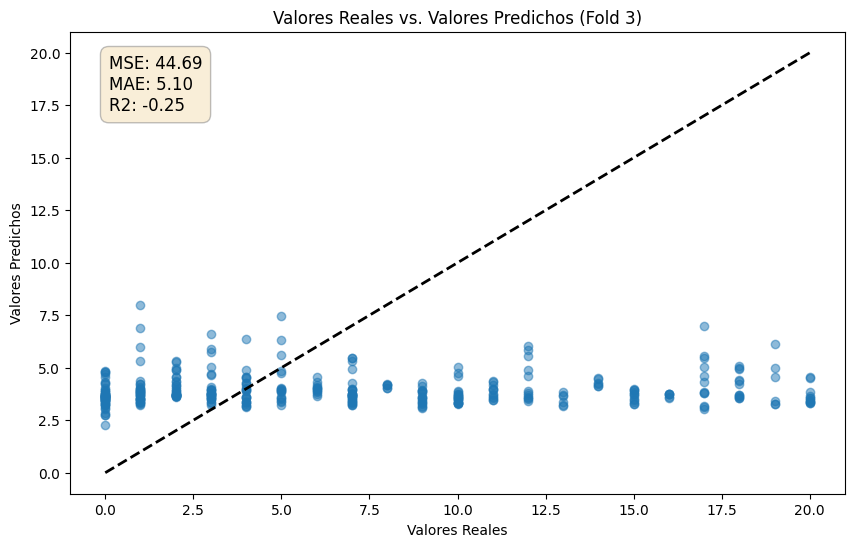

------------------------------------------------------------------------
Evaluating for K = 4 ...
------------------------------------------------------------------------
------------------------------------------------------------------------
Evaluating for fold 1 ...


c:\Users\herna\anaconda3\envs\SpectroCNN\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Part

Epoch 1/100
68/68 [==============================] - 14s 201ms/step - loss: 2341.2041 - mean_absolute_error: 30.5355 - val_loss: 60.2942 - val_mean_absolute_error: 5.5744 - lr: 0.0010
Epoch 2/100
68/68 [==============================] - 13s 189ms/step - loss: 115.9542 - mean_absolute_error: 7.5774 - val_loss: 30.8831 - val_mean_absolute_error: 3.8957 - lr: 0.0010
Epoch 3/100
68/68 [==============================] - 13s 195ms/step - loss: 56.1766 - mean_absolute_error: 5.8925 - val_loss: 28.6074 - val_mean_absolute_error: 3.8548 - lr: 0.0010
Epoch 4/100
68/68 [==============================] - 12s 175ms/step - loss: 73.1825 - mean_absolute_error: 6.4381 - val_loss: 27.4397 - val_mean_absolute_error: 3.4997 - lr: 0.0010
Epoch 5/100
68/68 [==============================] - 7s 104ms/step - loss: 61.0220 - mean_absolute_error: 6.0930 - val_loss: 28.6140 - val_mean_absolute_error: 3.6533 - lr: 0.0010
Epoch 6/100
68/68 [==============================] - 7s 105ms/step - loss: 49.9819 - mean_ab

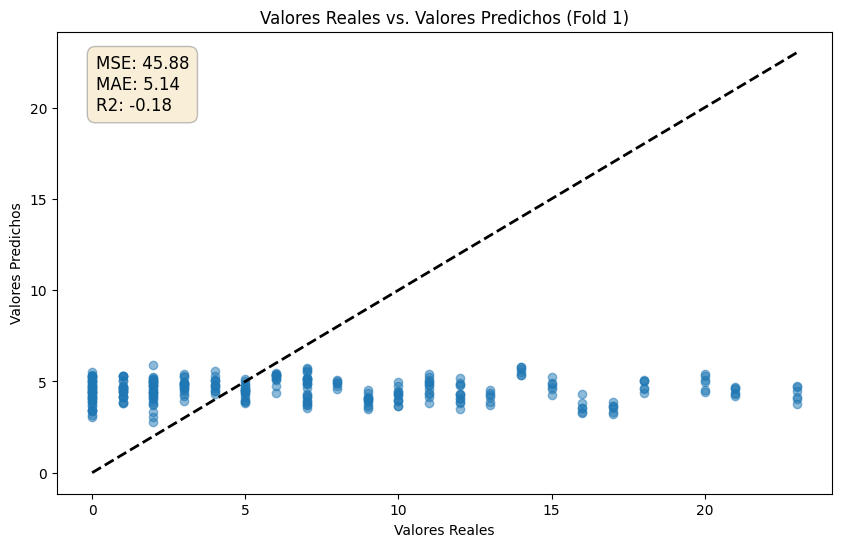

------------------------------------------------------------------------
Evaluating for fold 2 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
69/69 [==============================] - 17s 233ms/step - loss: 4405.6763 - mean_absolute_error: 43.8308 - val_loss: 69.4820 - val_mean_absolute_error: 6.8918 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 14s 203ms/step - loss: 179.0647 - mean_absolute_error: 10.1770 - val_loss: 39.9184 - val_mean_absolute_error: 4.3766 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 18s 262ms/step - loss: 82.3708 - mean_absolute_error: 7.1415 - val_loss: 33.9672 - val_mean_absolute_error: 4.4109 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - 8s 118ms/step - loss: 64.5435 - mean_absolute_error: 6.4870 - val_loss: 37.5821 - val_mean_absolute_error: 5.0501 - lr: 0.0010
Epoch 5/100
69/69 [==============================] - 13s 188ms/step - loss: 59.5356 - mean_absolute_error: 6.1831 - val_loss: 32.6984 - val_mean_absolute_error: 4.4622 - lr: 0.0010
Epoch 6/100
69/69 [==============================] - 14s 202ms/step - loss: 54.2222 - mean_

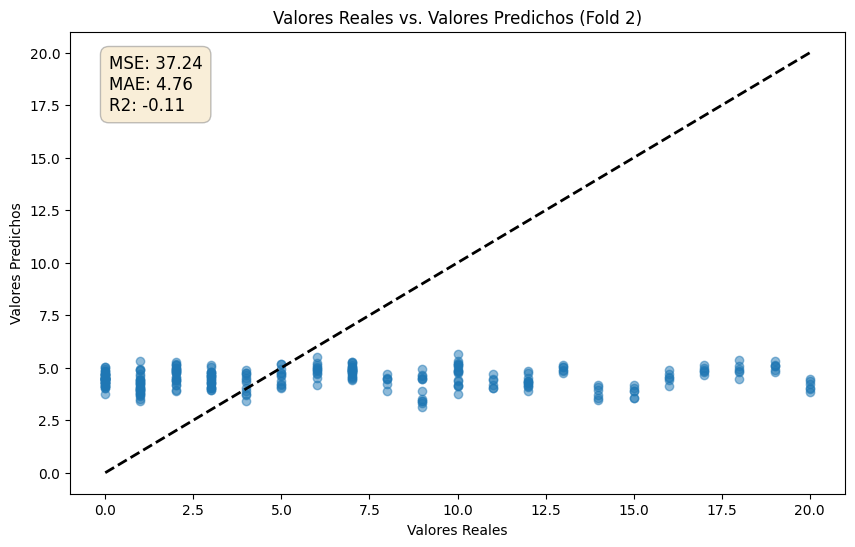

------------------------------------------------------------------------
Evaluating for fold 3 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
69/69 [==============================] - 14s 194ms/step - loss: 3621.0022 - mean_absolute_error: 38.9879 - val_loss: 487.9677 - val_mean_absolute_error: 14.5965 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 14s 201ms/step - loss: 103.1901 - mean_absolute_error: 7.7050 - val_loss: 38.2088 - val_mean_absolute_error: 4.5034 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 13s 186ms/step - loss: 59.2790 - mean_absolute_error: 6.1707 - val_loss: 34.1182 - val_mean_absolute_error: 4.7645 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - 13s 186ms/step - loss: 51.2241 - mean_absolute_error: 5.7217 - val_loss: 32.9392 - val_mean_absolute_error: 4.8293 - lr: 0.0010
Epoch 5/100
69/69 [==============================] - 12s 178ms/step - loss: 47.2667 - mean_absolute_error: 5.5281 - val_loss: 32.6951 - val_mean_absolute_error: 4.7384 - lr: 0.0010
Epoch 6/100
69/69 [==============================] - 8s 106ms/step - loss: 48.2880 - mean

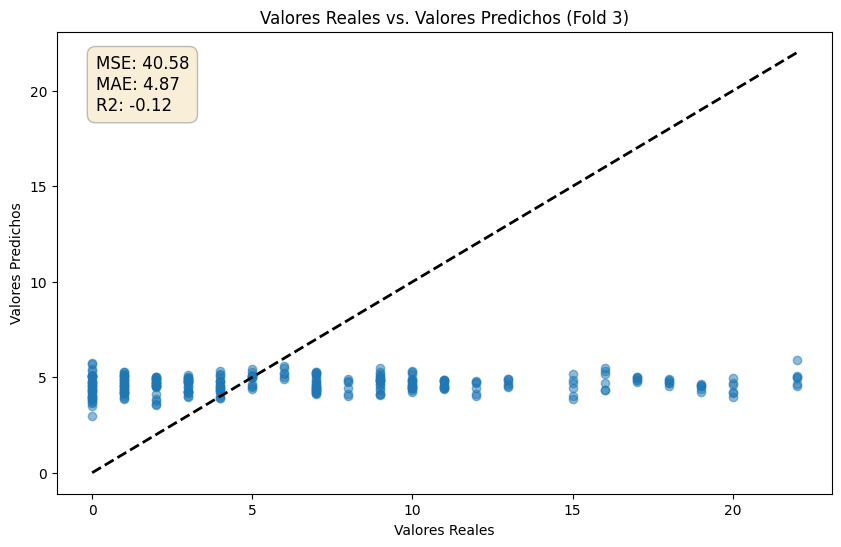

------------------------------------------------------------------------
Evaluating for fold 4 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
69/69 [==============================] - 13s 184ms/step - loss: 2589.4124 - mean_absolute_error: 33.9548 - val_loss: 3154.2700 - val_mean_absolute_error: 41.0601 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 13s 186ms/step - loss: 131.2259 - mean_absolute_error: 8.1505 - val_loss: 29.7027 - val_mean_absolute_error: 3.8606 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 13s 191ms/step - loss: 69.4987 - mean_absolute_error: 6.4122 - val_loss: 29.1358 - val_mean_absolute_error: 3.7955 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - 8s 112ms/step - loss: 60.1480 - mean_absolute_error: 5.9540 - val_loss: 29.1928 - val_mean_absolute_error: 3.8432 - lr: 0.0010
Epoch 5/100
69/69 [==============================] - 8s 115ms/step - loss: 53.7185 - mean_absolute_error: 5.7605 - val_loss: 29.3651 - val_mean_absolute_error: 3.7557 - lr: 0.0010
Epoch 6/100
69/69 [==============================] - 8s 116ms/step - loss: 48.9433 - mean_

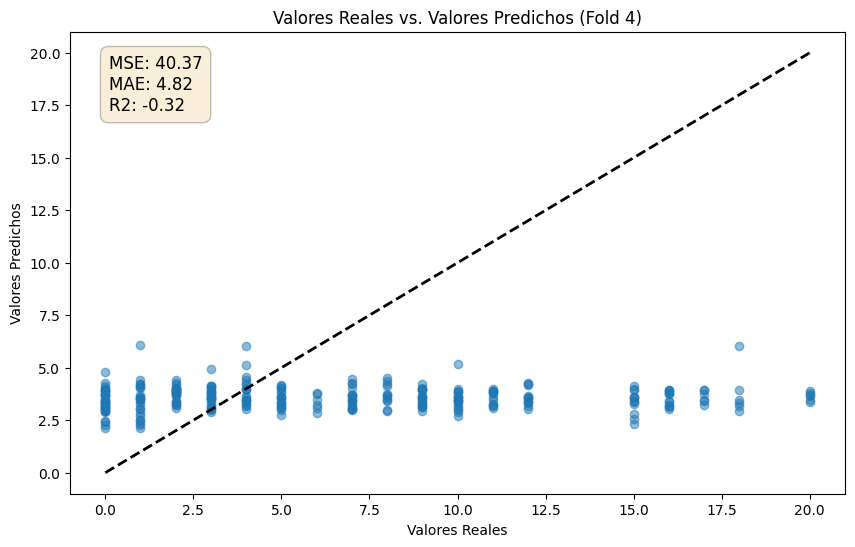

------------------------------------------------------------------------
Evaluating for K = 5 ...
------------------------------------------------------------------------
------------------------------------------------------------------------
Evaluating for fold 1 ...


c:\Users\herna\anaconda3\envs\SpectroCNN\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Part

Epoch 1/100
73/73 [==============================] - 15s 196ms/step - loss: 2547.4749 - mean_absolute_error: 28.9322 - val_loss: 945.1006 - val_mean_absolute_error: 22.5287 - lr: 0.0010
Epoch 2/100
73/73 [==============================] - 14s 185ms/step - loss: 88.4637 - mean_absolute_error: 6.8468 - val_loss: 320.2977 - val_mean_absolute_error: 11.0747 - lr: 0.0010
Epoch 3/100
73/73 [==============================] - 14s 192ms/step - loss: 74.9545 - mean_absolute_error: 6.7196 - val_loss: 28.6029 - val_mean_absolute_error: 4.4675 - lr: 0.0010
Epoch 4/100
73/73 [==============================] - 14s 183ms/step - loss: 56.2931 - mean_absolute_error: 6.0323 - val_loss: 22.3176 - val_mean_absolute_error: 3.7594 - lr: 0.0010
Epoch 5/100
73/73 [==============================] - 13s 181ms/step - loss: 57.5472 - mean_absolute_error: 5.9242 - val_loss: 19.8487 - val_mean_absolute_error: 3.2313 - lr: 0.0010
Epoch 6/100
73/73 [==============================] - 9s 119ms/step - loss: 75.6920 - mea

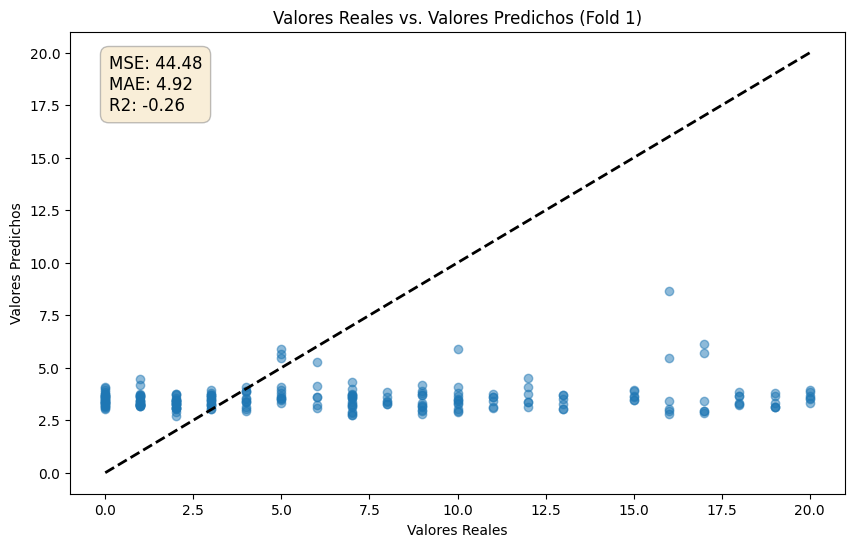

------------------------------------------------------------------------
Evaluating for fold 2 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
73/73 [==============================] - 16s 205ms/step - loss: 3178.7515 - mean_absolute_error: 34.5715 - val_loss: 46.3073 - val_mean_absolute_error: 4.6116 - lr: 0.0010
Epoch 2/100
73/73 [==============================] - 15s 197ms/step - loss: 92.7373 - mean_absolute_error: 7.0905 - val_loss: 36.7824 - val_mean_absolute_error: 4.8453 - lr: 0.0010
Epoch 3/100
73/73 [==============================] - 14s 189ms/step - loss: 64.2438 - mean_absolute_error: 6.3370 - val_loss: 33.3154 - val_mean_absolute_error: 4.4384 - lr: 0.0010
Epoch 4/100
73/73 [==============================] - 9s 125ms/step - loss: 61.2819 - mean_absolute_error: 6.1624 - val_loss: 33.8628 - val_mean_absolute_error: 4.3756 - lr: 0.0010
Epoch 5/100
73/73 [==============================] - 9s 122ms/step - loss: 50.3870 - mean_absolute_error: 5.4849 - val_loss: 33.9781 - val_mean_absolute_error: 4.3729 - lr: 0.0010
Epoch 6/100
73/73 [==============================] - 9s 128ms/step - loss: 49.3303 - mean_abso

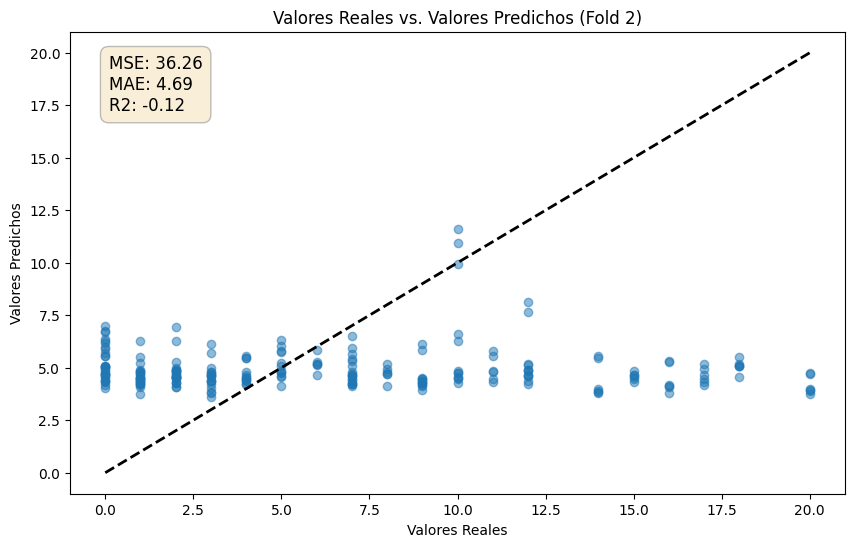

------------------------------------------------------------------------
Evaluating for fold 3 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
73/73 [==============================] - 16s 213ms/step - loss: 3506.4619 - mean_absolute_error: 36.7153 - val_loss: 42.2151 - val_mean_absolute_error: 4.7472 - lr: 0.0010
Epoch 2/100
73/73 [==============================] - 8s 110ms/step - loss: 81.1390 - mean_absolute_error: 7.2424 - val_loss: 55.4798 - val_mean_absolute_error: 6.4025 - lr: 0.0010
Epoch 3/100
73/73 [==============================] - 9s 123ms/step - loss: 67.9549 - mean_absolute_error: 6.5331 - val_loss: 48.6698 - val_mean_absolute_error: 6.0109 - lr: 0.0010
Epoch 4/100
73/73 [==============================] - 10s 133ms/step - loss: 70.2819 - mean_absolute_error: 6.4902 - val_loss: 45.5259 - val_mean_absolute_error: 6.1017 - lr: 0.0010
Epoch 5/100
73/73 [==============================] - 13s 186ms/step - loss: 59.1090 - mean_absolute_error: 6.1583 - val_loss: 41.4494 - val_mean_absolute_error: 5.6582 - lr: 1.0000e-04
Epoch 6/100
73/73 [==============================] - 14s 182ms/step - loss: 54.1104 - mean

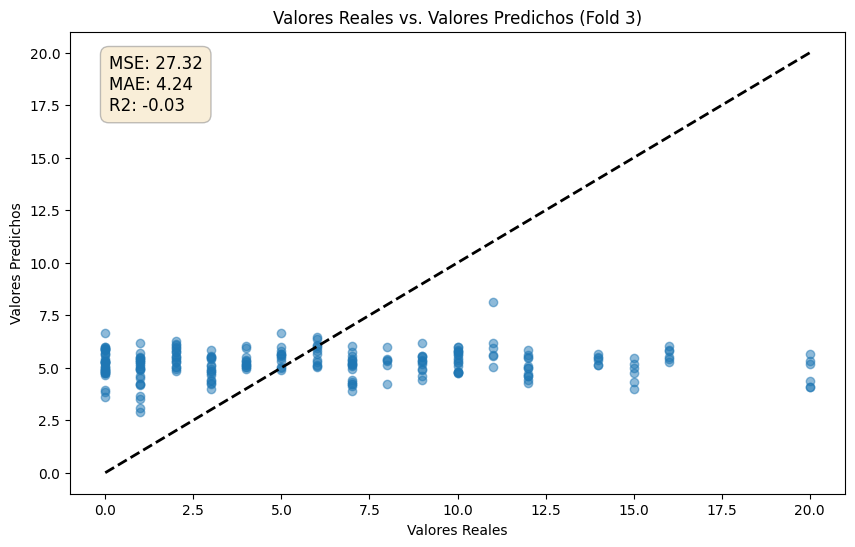

------------------------------------------------------------------------
Evaluating for fold 4 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
73/73 [==============================] - 15s 191ms/step - loss: 3070.6416 - mean_absolute_error: 28.5689 - val_loss: 271.8166 - val_mean_absolute_error: 10.9584 - lr: 0.0010
Epoch 2/100
73/73 [==============================] - 13s 179ms/step - loss: 83.8485 - mean_absolute_error: 6.6441 - val_loss: 34.9650 - val_mean_absolute_error: 3.6213 - lr: 0.0010
Epoch 3/100
73/73 [==============================] - 13s 172ms/step - loss: 57.9651 - mean_absolute_error: 6.1179 - val_loss: 31.4324 - val_mean_absolute_error: 3.6048 - lr: 0.0010
Epoch 4/100
73/73 [==============================] - 13s 170ms/step - loss: 52.6224 - mean_absolute_error: 5.8024 - val_loss: 29.6452 - val_mean_absolute_error: 3.6679 - lr: 0.0010
Epoch 5/100
73/73 [==============================] - 13s 180ms/step - loss: 44.1099 - mean_absolute_error: 5.3080 - val_loss: 28.9771 - val_mean_absolute_error: 3.7078 - lr: 0.0010
Epoch 6/100
73/73 [==============================] - 13s 172ms/step - loss: 43.5019 - mean

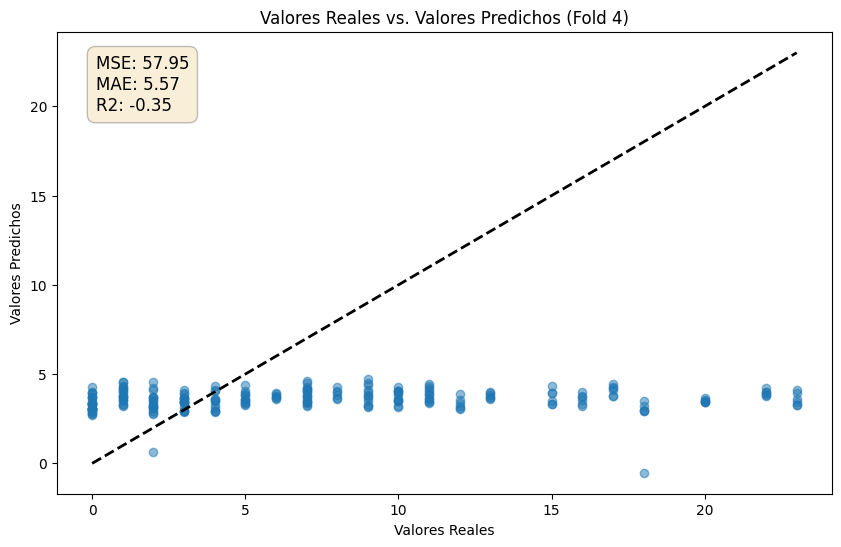

------------------------------------------------------------------------
Evaluating for fold 5 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
73/73 [==============================] - 14s 189ms/step - loss: 2264.5371 - mean_absolute_error: 28.3219 - val_loss: 51.5518 - val_mean_absolute_error: 4.7411 - lr: 0.0010
Epoch 2/100
73/73 [==============================] - 13s 181ms/step - loss: 84.9304 - mean_absolute_error: 7.1622 - val_loss: 31.9783 - val_mean_absolute_error: 4.1756 - lr: 0.0010
Epoch 3/100
73/73 [==============================] - 13s 183ms/step - loss: 68.1551 - mean_absolute_error: 6.4659 - val_loss: 30.9269 - val_mean_absolute_error: 4.2661 - lr: 0.0010
Epoch 4/100
73/73 [==============================] - 13s 180ms/step - loss: 62.1982 - mean_absolute_error: 6.2213 - val_loss: 30.0593 - val_mean_absolute_error: 4.1190 - lr: 0.0010
Epoch 5/100
73/73 [==============================] - 9s 115ms/step - loss: 53.0626 - mean_absolute_error: 5.7475 - val_loss: 32.7490 - val_mean_absolute_error: 4.3268 - lr: 0.0010
Epoch 6/100
73/73 [==============================] - 8s 107ms/step - loss: 53.7601 - mean_abs

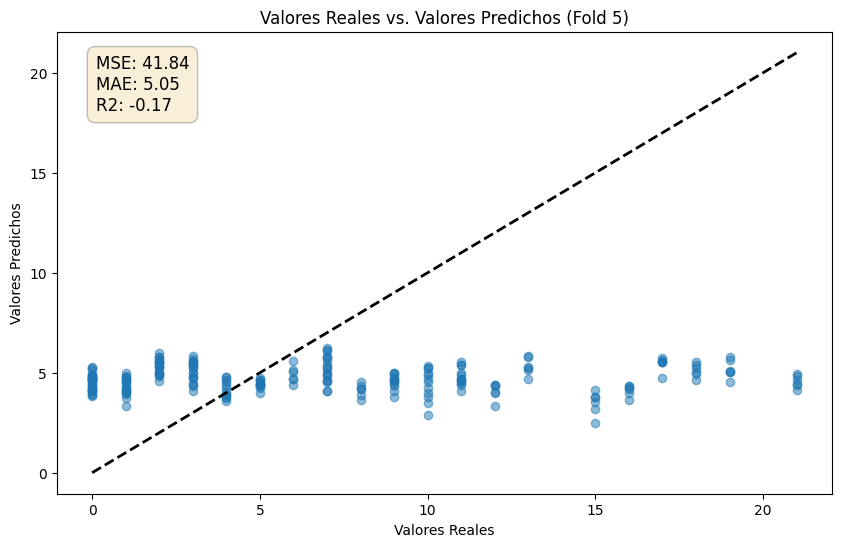

------------------------------------------------------------------------
Evaluating for K = 10 ...
------------------------------------------------------------------------
------------------------------------------------------------------------
Evaluating for fold 1 ...


c:\Users\herna\anaconda3\envs\SpectroCNN\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Par

Epoch 1/100
82/82 [==============================] - 15s 180ms/step - loss: 4253.0776 - mean_absolute_error: 43.3004 - val_loss: 2407.0232 - val_mean_absolute_error: 33.1990 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 15s 184ms/step - loss: 163.9463 - mean_absolute_error: 8.7362 - val_loss: 37.0762 - val_mean_absolute_error: 4.4778 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 15s 175ms/step - loss: 77.9157 - mean_absolute_error: 6.9107 - val_loss: 35.4717 - val_mean_absolute_error: 4.7055 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 16s 190ms/step - loss: 77.3243 - mean_absolute_error: 6.7339 - val_loss: 33.7855 - val_mean_absolute_error: 4.6129 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 16s 193ms/step - loss: 61.9987 - mean_absolute_error: 6.1200 - val_loss: 33.5263 - val_mean_absolute_error: 4.5174 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 10s 124ms/step - loss: 56.3770 - me

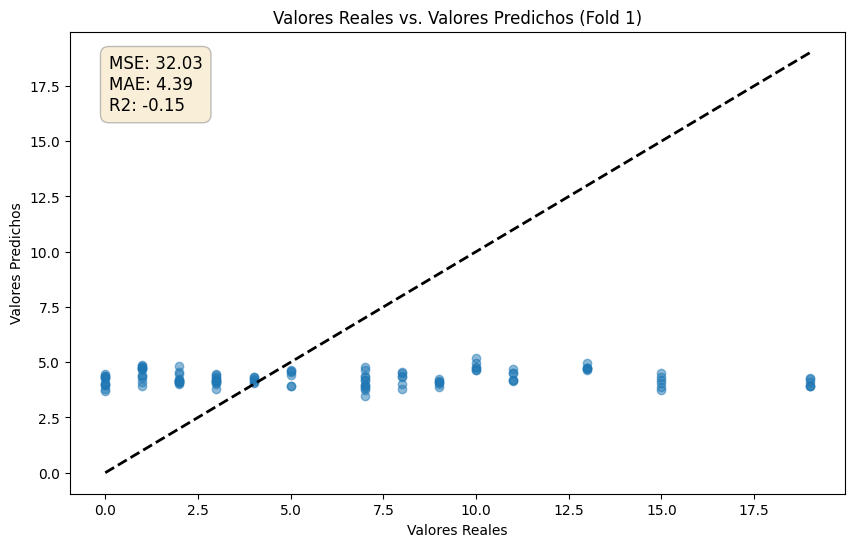

------------------------------------------------------------------------
Evaluating for fold 2 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
82/82 [==============================] - 16s 186ms/step - loss: 3171.2573 - mean_absolute_error: 27.7718 - val_loss: 64.8444 - val_mean_absolute_error: 6.2477 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 15s 180ms/step - loss: 93.0379 - mean_absolute_error: 7.2379 - val_loss: 37.0386 - val_mean_absolute_error: 3.9359 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 16s 188ms/step - loss: 61.8157 - mean_absolute_error: 6.3037 - val_loss: 35.0384 - val_mean_absolute_error: 3.8863 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 16s 192ms/step - loss: 56.9166 - mean_absolute_error: 6.0551 - val_loss: 33.7976 - val_mean_absolute_error: 3.9250 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 17s 208ms/step - loss: 50.7592 - mean_absolute_error: 5.6777 - val_loss: 33.1113 - val_mean_absolute_error: 3.8546 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 16s 196ms/step - loss: 49.9101 - mean_a

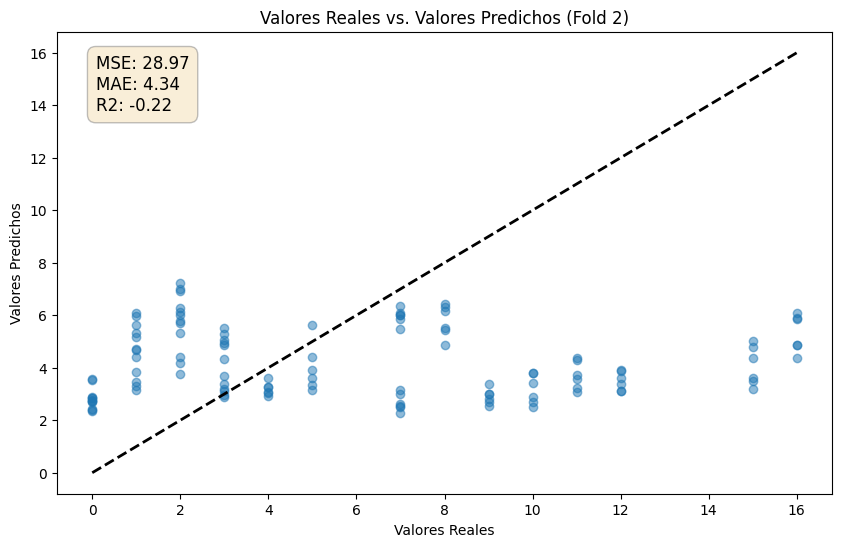

------------------------------------------------------------------------
Evaluating for fold 3 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
82/82 [==============================] - 16s 187ms/step - loss: 4328.6870 - mean_absolute_error: 41.2508 - val_loss: 168.9598 - val_mean_absolute_error: 9.9892 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 14s 170ms/step - loss: 158.5673 - mean_absolute_error: 8.2422 - val_loss: 35.9415 - val_mean_absolute_error: 4.3632 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 10s 120ms/step - loss: 81.7891 - mean_absolute_error: 6.9362 - val_loss: 37.5483 - val_mean_absolute_error: 4.9846 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 15s 183ms/step - loss: 82.4028 - mean_absolute_error: 6.8071 - val_loss: 33.9424 - val_mean_absolute_error: 4.3854 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 16s 196ms/step - loss: 64.1398 - mean_absolute_error: 6.2965 - val_loss: 33.5239 - val_mean_absolute_error: 4.4217 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 16s 196ms/step - loss: 59.4949 - mean

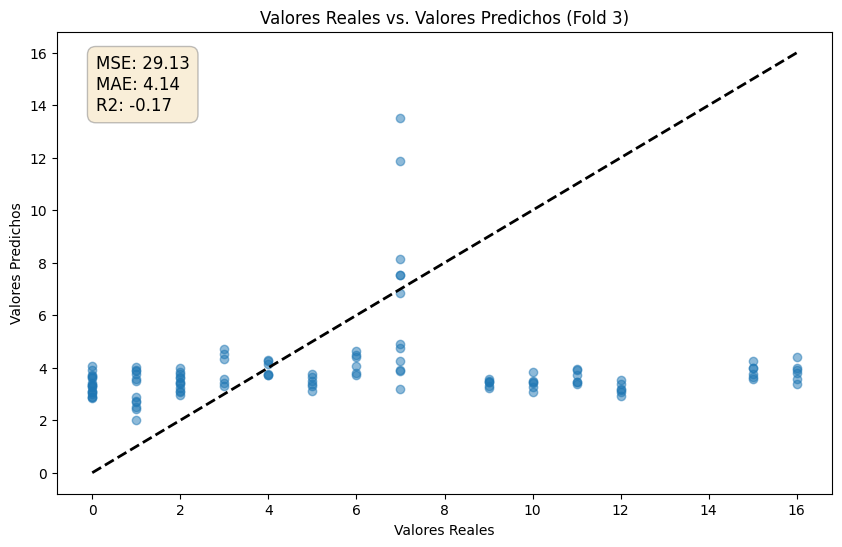

------------------------------------------------------------------------
Evaluating for fold 4 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
82/82 [==============================] - 16s 189ms/step - loss: 4648.7388 - mean_absolute_error: 41.9690 - val_loss: 1193.6260 - val_mean_absolute_error: 28.8055 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 17s 212ms/step - loss: 150.7438 - mean_absolute_error: 8.5654 - val_loss: 50.1588 - val_mean_absolute_error: 5.2243 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 15s 180ms/step - loss: 102.1560 - mean_absolute_error: 7.3035 - val_loss: 46.1594 - val_mean_absolute_error: 5.0742 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 15s 179ms/step - loss: 67.8525 - mean_absolute_error: 6.4946 - val_loss: 28.0402 - val_mean_absolute_error: 3.5118 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 14s 172ms/step - loss: 57.1701 - mean_absolute_error: 6.0163 - val_loss: 27.0316 - val_mean_absolute_error: 3.5589 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 9s 108ms/step - loss: 50.9866 - me

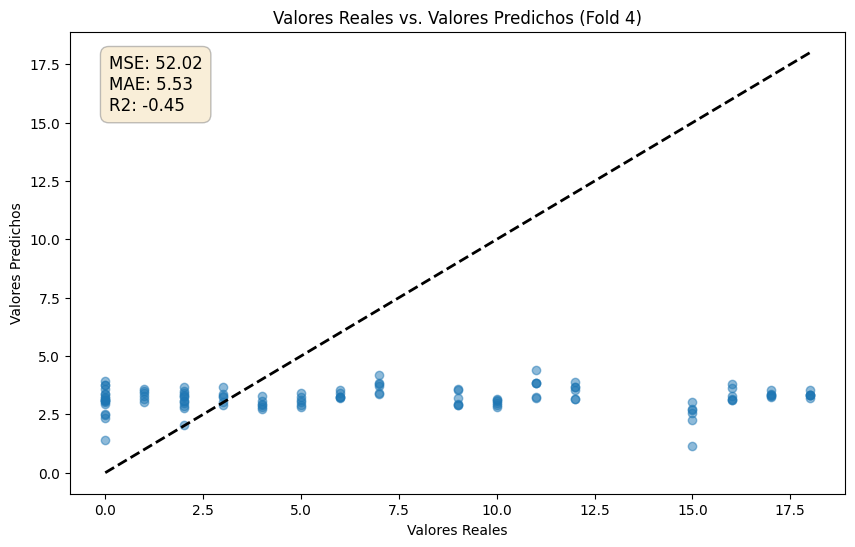

------------------------------------------------------------------------
Evaluating for fold 5 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
82/82 [==============================] - 16s 186ms/step - loss: 2412.7048 - mean_absolute_error: 28.5358 - val_loss: 58.2448 - val_mean_absolute_error: 5.1509 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 15s 178ms/step - loss: 121.7102 - mean_absolute_error: 7.7016 - val_loss: 21.7760 - val_mean_absolute_error: 3.2179 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 9s 107ms/step - loss: 77.6434 - mean_absolute_error: 6.7316 - val_loss: 22.6523 - val_mean_absolute_error: 3.6538 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 9s 108ms/step - loss: 67.1533 - mean_absolute_error: 6.4855 - val_loss: 23.8025 - val_mean_absolute_error: 3.6819 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 9s 115ms/step - loss: 48.9204 - mean_absolute_error: 5.5025 - val_loss: 25.7539 - val_mean_absolute_error: 3.4842 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 14s 172ms/step - loss: 51.5926 - mean_abs

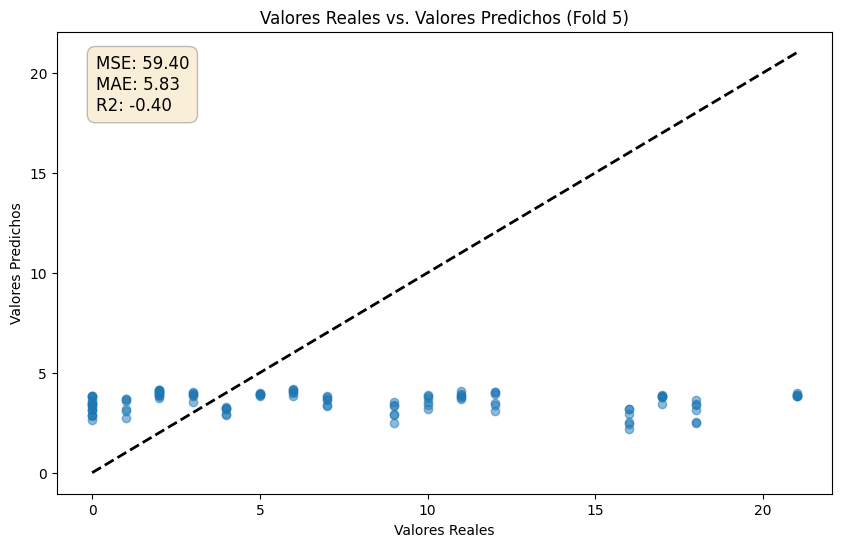

------------------------------------------------------------------------
Evaluating for fold 6 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
82/82 [==============================] - 16s 187ms/step - loss: 2091.6582 - mean_absolute_error: 24.3503 - val_loss: 247.8980 - val_mean_absolute_error: 11.0815 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 17s 201ms/step - loss: 102.7908 - mean_absolute_error: 6.8789 - val_loss: 38.8275 - val_mean_absolute_error: 4.1938 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 14s 174ms/step - loss: 70.0164 - mean_absolute_error: 6.4194 - val_loss: 35.2789 - val_mean_absolute_error: 4.4371 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 9s 105ms/step - loss: 919.2048 - mean_absolute_error: 11.3658 - val_loss: 1273.7388 - val_mean_absolute_error: 27.6144 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 9s 111ms/step - loss: 164.6497 - mean_absolute_error: 7.6765 - val_loss: 453.7443 - val_mean_absolute_error: 11.4516 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 9s 105ms/step - loss: 53.0933 

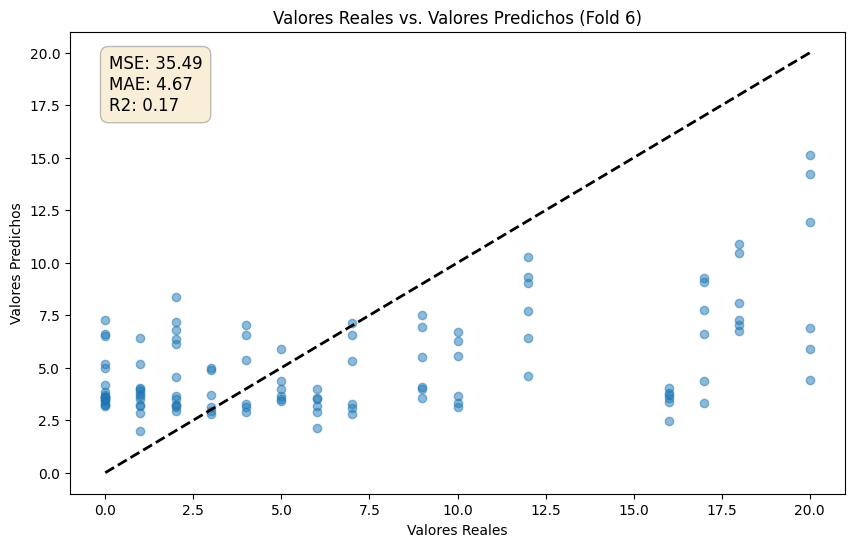

------------------------------------------------------------------------
Evaluating for fold 7 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
82/82 [==============================] - 16s 188ms/step - loss: 1781.0654 - mean_absolute_error: 24.5276 - val_loss: 36.6866 - val_mean_absolute_error: 4.3523 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 15s 184ms/step - loss: 103.2611 - mean_absolute_error: 6.9726 - val_loss: 31.7814 - val_mean_absolute_error: 4.3405 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 10s 119ms/step - loss: 56.6525 - mean_absolute_error: 5.8730 - val_loss: 33.5802 - val_mean_absolute_error: 4.4421 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 9s 113ms/step - loss: 50.7220 - mean_absolute_error: 5.6202 - val_loss: 32.3279 - val_mean_absolute_error: 4.1405 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 9s 108ms/step - loss: 44.9155 - mean_absolute_error: 5.3344 - val_loss: 31.9443 - val_mean_absolute_error: 4.0898 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 10s 117ms/step - loss: 45.8722 - mean_ab

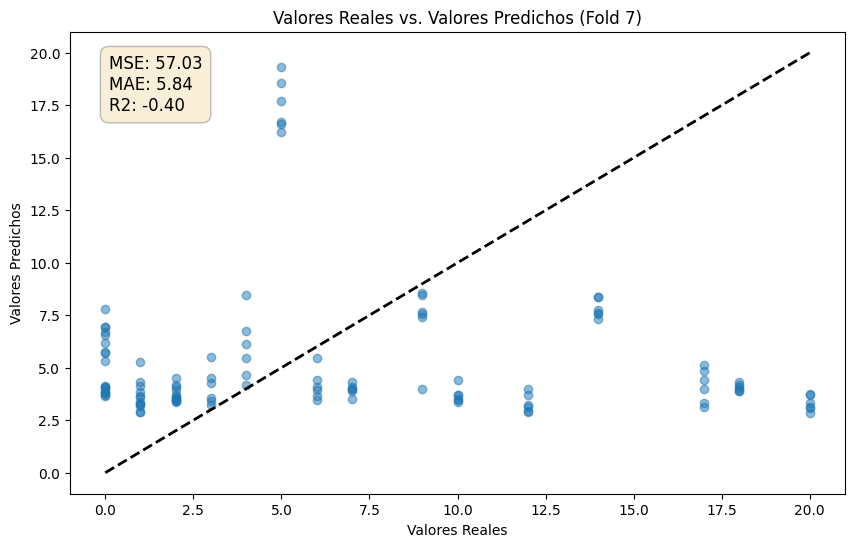

------------------------------------------------------------------------
Evaluating for fold 8 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
82/82 [==============================] - 15s 181ms/step - loss: 2812.4226 - mean_absolute_error: 32.4591 - val_loss: 1053.0897 - val_mean_absolute_error: 20.7655 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 15s 180ms/step - loss: 74.5879 - mean_absolute_error: 6.9706 - val_loss: 28.5664 - val_mean_absolute_error: 3.6870 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 14s 170ms/step - loss: 58.1861 - mean_absolute_error: 6.1192 - val_loss: 25.9383 - val_mean_absolute_error: 3.5729 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 15s 185ms/step - loss: 52.6722 - mean_absolute_error: 5.8002 - val_loss: 25.5264 - val_mean_absolute_error: 3.3877 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 15s 176ms/step - loss: 50.6221 - mean_absolute_error: 5.6569 - val_loss: 23.9687 - val_mean_absolute_error: 3.4676 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 9s 111ms/step - loss: 48.5170 - mean

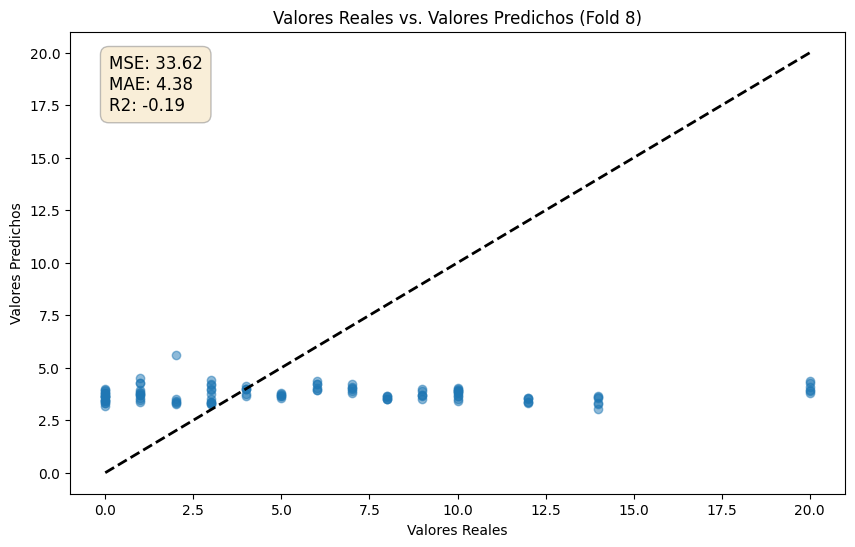

------------------------------------------------------------------------
Evaluating for fold 9 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
82/82 [==============================] - 15s 177ms/step - loss: 3147.9841 - mean_absolute_error: 31.2806 - val_loss: 73.9740 - val_mean_absolute_error: 5.3634 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 15s 183ms/step - loss: 164.7084 - mean_absolute_error: 8.3447 - val_loss: 38.1845 - val_mean_absolute_error: 4.7678 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 14s 171ms/step - loss: 78.1650 - mean_absolute_error: 6.7836 - val_loss: 33.0168 - val_mean_absolute_error: 4.5628 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 15s 178ms/step - loss: 57.2815 - mean_absolute_error: 6.0648 - val_loss: 32.6334 - val_mean_absolute_error: 4.4292 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 17s 204ms/step - loss: 52.6979 - mean_absolute_error: 5.7938 - val_loss: 31.7302 - val_mean_absolute_error: 4.1634 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 15s 186ms/step - loss: 48.2118 - mean_

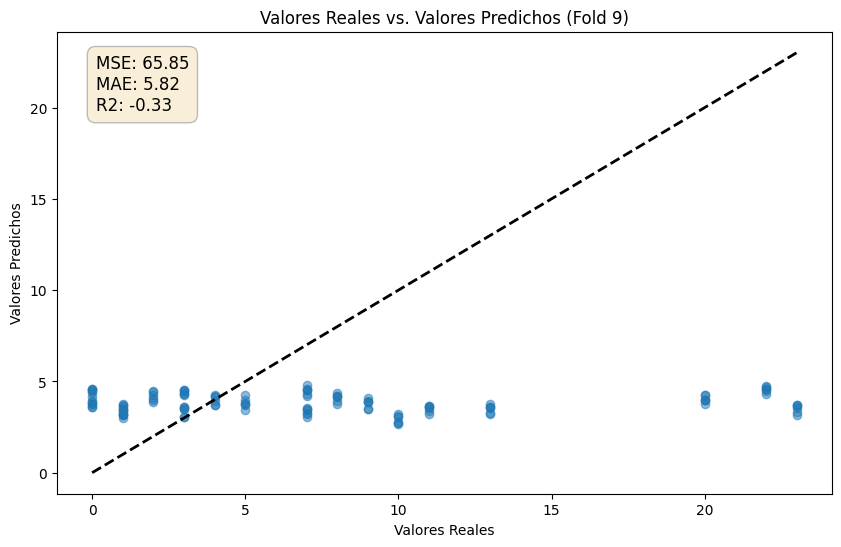

------------------------------------------------------------------------
Evaluating for fold 10 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
C:\Users\herna\AppData\Local\Temp\ipykernel_65912\1829795989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Epoch 1/100
82/82 [==============================] - 16s 184ms/step - loss: 3044.8589 - mean_absolute_error: 24.6199 - val_loss: 160.2690 - val_mean_absolute_error: 8.4989 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 14s 168ms/step - loss: 74.6791 - mean_absolute_error: 6.4308 - val_loss: 35.7215 - val_mean_absolute_error: 3.9465 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 15s 180ms/step - loss: 52.5144 - mean_absolute_error: 5.7424 - val_loss: 32.3819 - val_mean_absolute_error: 3.8300 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 16s 200ms/step - loss: 52.5933 - mean_absolute_error: 5.6430 - val_loss: 31.5856 - val_mean_absolute_error: 3.9068 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 9s 114ms/step - loss: 55.8151 - mean_absolute_error: 5.9399 - val_loss: 50.5210 - val_mean_absolute_error: 4.5324 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 10s 118ms/step - loss: 57.1789 - mean_a

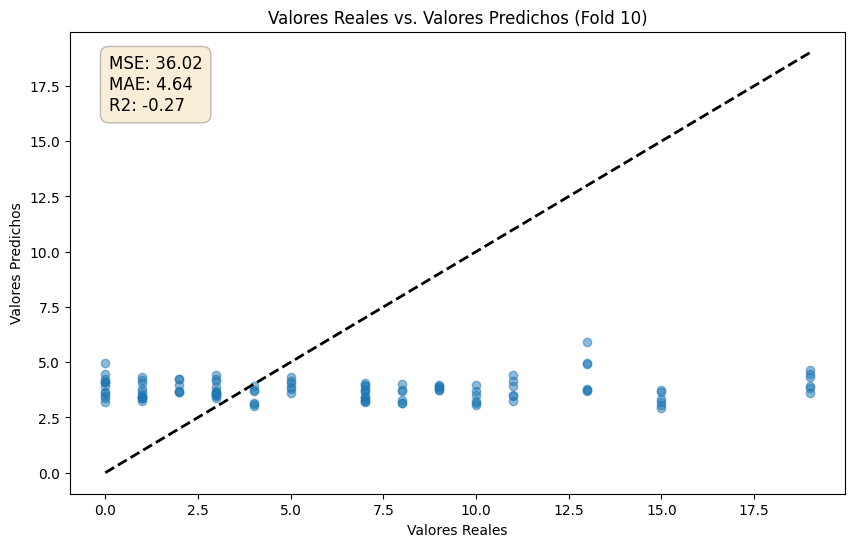

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Hiperparámetros
batch_size = 10
input_shape = (252, 792, 3)
no_epochs = 100
verbosity = 1

# Variables para almacenar las métricas de cada k, para calcular la media al final
mean_mse_list = []
mean_mae_list = []
mean_r2_list = []

# Crear objeto StratifiedKFold
k_list = [3, 4, 5, 10]

for current_k in k_list:
    print('------------------------------------------------------------------------')
    print(f'Evaluating for K = {current_k} ...')
    print('------------------------------------------------------------------------')
    
    skf = StratifiedKFold(n_splits=current_k, shuffle=True)
    
    mse_per_fold = []
    mae_per_fold = []
    r2_per_fold = []
    
    for fold_no, (train_indices, test_indices) in enumerate(skf.split(df_complete, df_complete['PHQ8_Score'])):
        print('------------------------------------------------------------------------')
        print(f'Evaluating for fold {fold_no + 1} ...')

        # Dividir los datos sin aumentar en conjuntos de entrenamiento y prueba
        X_train_unaugmented = df_complete.iloc[train_indices]
        y_train_unaugmented = df_complete.iloc[train_indices]
        X_test_unaugmented = df_complete.iloc[test_indices]
        y_test_unaugmented = df_complete.iloc[test_indices]

        # Cargar datos aumentados
        X_train_augmented = load_spectrogram(X_train_unaugmented)
        y_train_augmented = load_spectrogram(y_train_unaugmented)
        X_test_augmented = load_spectrogram(X_test_unaugmented)
        y_test_augmented = load_spectrogram(y_test_unaugmented)

        # Reestructurar los dataframes
        X_train = np.array(X_train_augmented['Spectrogram'].tolist())
        y_train = y_train_augmented['PHQ8_Score'].values
        X_test = np.array(X_test_augmented['Spectrogram'].tolist())
        y_test = y_test_augmented['PHQ8_Score'].values

        # Definir y compilar el modelo
        model = Sequential()
        model.add(BatchNormalization(input_shape=input_shape))  # Especifica input_shape
        model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dropout(0.5))
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='linear'))  # Para regresión lineal, usar activación 'linear'

        model.compile(optimizer=Adam(learning_rate=0.001), 
                      loss='mean_squared_error',  # Función de pérdida para regresión
                      metrics=['mean_absolute_error'])  # Métrica adicional para regresión

        # Ajustar el modelo en los datos de entrenamiento aumentados
        model.fit(X_train,
                  y_train, 
                  batch_size=batch_size, 
                  epochs=no_epochs, 
                  verbose=verbosity, 
                  validation_split=0.2,
                  callbacks=[
                      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                      tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
                  ])
        
        # Predecir valores
        y_pred = model.predict(X_test).flatten()
        
        # Calcular métricas
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        mse_per_fold.append(mse)
        mae_per_fold.append(mae)
        r2_per_fold.append(r2)
        
        # Crear un gráfico de dispersión para cada fold
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
        plt.xlabel('Valores Reales')
        plt.ylabel('Valores Predichos')
        plt.title(f'Valores Reales vs. Valores Predichos (Fold {fold_no + 1})')
        plt.text(0.05, 0.95, f'MSE: {mse:.2f}\nMAE: {mae:.2f}\nR2: {r2:.2f}', transform=plt.gca().transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='gray', facecolor='wheat', alpha=0.5))
        plt.show()

    # Calcular las medias
    mean_mse = np.mean(mse_per_fold)
    mean_mae = np.mean(mae_per_fold)
    mean_r2 = np.mean(r2_per_fold)
    
    # Almacenar las medias para el gráfico global
    mean_mse_list.append(mean_mse)
    mean_mae_list.append(mean_mae)
    mean_r2_list.append(mean_r2)

    folder_path = f'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/folds/newPreprocessV2/{current_k}_complete/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Escribir los valores medios en el archivo scores.txt
    with open(os.path.join(folder_path, 'scores.txt'), 'w') as file:
        file.write(f'Mean MSE: {mean_mse}\n')
        file.write(f'Mean MAE: {mean_mae}\n')
        file.write(f'Mean R2: {mean_r2}\n')
        
    # Graficar las métricas globales
    metrics = ['MSE', 'MAE', 'R2']
    values = [mean_mse, mean_mae, mean_r2]
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color='skyblue')
    plt.title("Model Metrics")
    plt.ylabel("Value")
    plt.savefig(os.path.join(folder_path, "model_metrics.jpg"))
    plt.close()
